In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from pykalman import KalmanFilter

## Data

In [2]:
df = pd.read_csv("./co2.csv", index_col=0)
df

,co2
date,
1987/1,353.2
1987/2,354.0
1987/3,354.8
1987/4,356.5
1987/5,354.7
...,...
2015/8,393.5
2015/9,395.1
2015/10,402.3


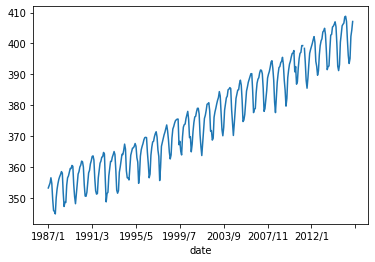

In [3]:
y = pd.Series(df["co2"].values, index=df.index)
y = y.astype('f')
y.plot()

In [4]:
y

date
1987/1     353.200012
1987/2     354.000000
1987/3     354.799988
1987/4     356.500000
1987/5     354.700012
              ...    
2015/8     393.500000
2015/9     395.100006
2015/10    402.299988
2015/11    404.299988
2015/12    407.100006
Length: 348, dtype: float32

## Forecast

In [5]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

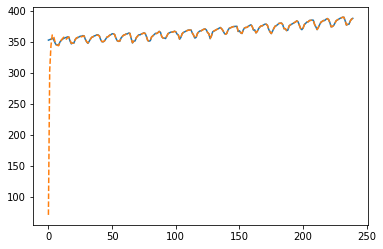

In [6]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series)
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

# 前半240時点を学習データに121時点以降のデータを検証用に使用
n_train = 240

train, test = y.values[:n_train], y.values[n_train:]
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

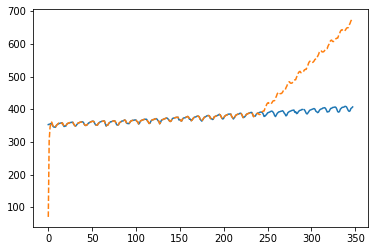

In [7]:
plt.plot(y.values, label="observation")

pred_y = np.empty(len(test))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

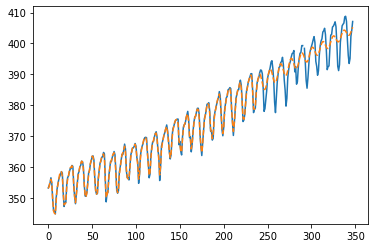

In [8]:
# EMアルゴリズムを用いたハイパーパラメタ最適化
emed_kf = kf.em(train, n_iter=10, em_vars='all')

# ハイパーパラメタF, H, Q, R更新後の平滑化系列
em_smoothed_state_means, em_smoothed_state_covs = emed_kf.smooth(train)
em_pred_o_smoothed = np.dot(em_smoothed_state_means, emed_kf.observation_matrices.T)
plt.plot(y.values, label="observation")

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

pred_y = np.empty(len(test))
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(np.hstack([em_pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

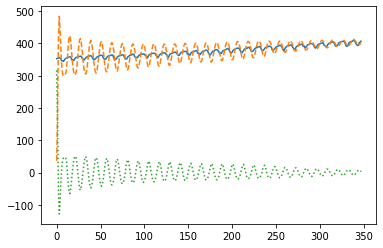

In [9]:
# 階差
diff = 2

# トレンド成分
# トレンド成分では階差の次数分の状態が対象
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], 
                              emed_kf.observation_matrices[:, :diff].T)
# 季節成分
# 季節成分は状態ベクトルにおいてトレンド成分以降の要素が対象
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:], 
                              emed_kf.observation_matrices[:, diff:].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# トレンド成分と季節成分の長期予測値を格納するベクトルを用意
t_pred_y = np.empty(len(test))
s_pred_y = np.empty(len(test))
# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, 
                                                       current_cov, 
                                                       observation=None)
    t_pred_y[i] = \
        emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = \
        emed_kf.observation_matrices[:, diff:].dot(current_state[diff:])

plt.plot(y.values, label="observation")
plt.plot(np.hstack([t_em_pred_o_smoothed.flatten(), t_pred_y]),
         '--', label="trend")
plt.plot(np.hstack([s_em_pred_o_smoothed.flatten(), s_pred_y]),
         ':', label="seasonal")

# トレンド成分＋季節成分の表示をしたい場合は以下のコメントアウトを外す
# plt.plot(
#     np.hstack([
#         s_em_pred_o_smoothed.flatten()+t_em_pred_o_smoothed.flatten(),
#         s_pred_y+t_pred_y]),
#     '+-', label="forecast")

In [10]:
emed_kf.observation_matrices.dot(em_smoothed_state_covs).shape

(1, 240, 13)

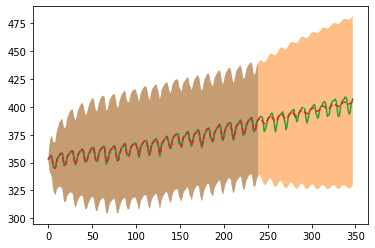

In [11]:
from scipy.stats import norm

# n_trainは訓練時点数
n_train = len(em_smoothed_state_covs)

# y_tの予測分布の分散
pred_cov = emed_kf.observation_matrices.dot(
    np.abs(em_smoothed_state_covs)).transpose(1,0,2).dot(emed_kf.observation_matrices.T)
# y_tの予測分布の平均
pred_mean = em_smoothed_state_means.dot(emed_kf.observation_matrices.T)

# 訓練データにおける推定値の95%信用区間の上下限
lower, upper = norm.interval(0.95, pred_mean.flatten(), scale=np.sqrt(pred_cov.flatten()))

plt.plot(train, label="observation")
plt.plot(em_pred_o_smoothed, '--', label="predict")
plt.fill_between(range(len(train)), upper,lower, alpha=0.5, label="credible interval")

# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series - 1
# トレンド成分
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], emed_kf.observation_matrices[:, :diff].T)
# 季節成分
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:se], emed_kf.observation_matrices[:, diff:se].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# 訓練データ数
n_test = len(test)
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y = np.empty(n_test)
# 季節成分
s_pred_y = np.empty(n_test)
# 95%信用区間の下限
inf_lower = np.empty(n_test)
# 95%信用区間の上限
inf_upper = np.empty(n_test)

# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    t_pred_y[i] = emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = emed_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])

    # y_tの予測分布の分散
    pred_cov = emed_kf.observation_matrices.dot(np.abs(current_cov)).dot(emed_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(emed_kf.observation_matrices.T)
    inf_lower[i], inf_upper[i] = norm.interval(0.95, pred_mean, scale=np.sqrt(pred_cov))
    
plt.plot(y.values, label="observation")
plt.plot(np.hstack([em_pred_o_smoothed.flatten(), t_pred_y+s_pred_y]), '--', label="forecast")
all_lower = np.hstack([lower, inf_lower])
all_upper = np.hstack([upper, inf_upper])
plt.fill_between(range(len(y.values)), all_upper, all_lower, alpha=0.5, label="credible interval")

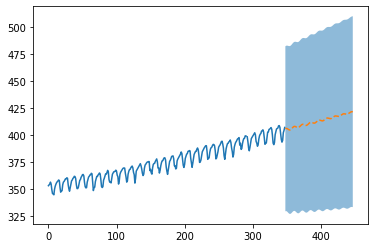

In [12]:
# さらに先の予測

# 訓練データ数
n_test2 = 100
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y2 = np.empty(n_test2)
# 季節成分
s_pred_y2 = np.empty(n_test2)
# 95%信用区間の下限
inf_lower2 = np.empty(n_test2)
# 95%信用区間の上限
inf_upper2 = np.empty(n_test2)

for i in range(n_test2):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    t_pred_y2[i] = emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y2[i] = emed_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])

    # y_tの予測分布の分散
    pred_cov = emed_kf.observation_matrices.dot(np.abs(current_cov)).dot(emed_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(emed_kf.observation_matrices.T)
    inf_lower2[i], inf_upper2[i] = norm.interval(0.95, pred_mean, scale=np.sqrt(pred_cov))

plt.plot(y.values, label="observation")
forecast = np.zeros(len(y.values))
forecast[:] = np.nan
plt.plot(np.hstack([forecast, t_pred_y2+s_pred_y2]), '--', label="forecast")
plt.fill_between(range(len(y.values), len(y.values)+n_test2), inf_upper2, inf_lower2, alpha=0.5, label="credible interval")

## Refactoring

In [13]:
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from scipy.stats import norm
from pykalman import KalmanFilter

In [14]:
import numpy as np

np.random.seed(555)
import pandas as pd
from scipy.stats import norm
from pykalman import KalmanFilter


class KfForecaster:
    def __init__(
            self,
            df,
            seasonal_freq,
            initial_state_mean=None,
            initial_state_covariance=None,
            transition_covariance=None,
            observation_covariance=None,
    ):

        df.index = pd.to_datetime(df.index)
        df.index.name = 'date'
        df = df.interpolate()
        self.df = df

        self.df_result = None

        n_dim_trend = 2
        # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        self.seasonal_freq = pd.Timedelta(seasonal_freq)
        self.data_interval = self.df.index[1] - self.df.index[0]
        n_data_seasonal_freq = round(self.seasonal_freq / self.data_interval)
        obs = self.df.iloc[:, 0].values

        self.obs = np.array(obs)
        self.n_dim_obs = obs.ndim
        self.n_obs = len(self.obs)
        self.n_dim_trend = n_dim_trend
        self.n_dim_series = n_data_seasonal_freq
        self.n_dim_state = self.get_n_dim_state()

        initial_state_mean = np.zeros(self.n_dim_state)
        initial_state_covariance = np.ones((self.n_dim_state, self.n_dim_state))

        F, Q, H, R = self.init_kf_params()
        self.kf = KalmanFilter(
            n_dim_obs=self.n_dim_obs,
            n_dim_state=self.n_dim_state,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            transition_matrices=F,
            transition_covariance=transition_covariance if transition_covariance is not None else Q,
            observation_matrices=H,
            observation_covariance=observation_covariance if observation_covariance is not None else R,
        )
        self.optimize_kf_params()

        self.smoothed_state_means = np.zeros(self.n_obs)
        self.smoothed_state_covs = np.zeros((self.n_obs, self.n_dim_state, self.n_dim_state))

    """
    F: transition matrices (k x k)
    Q: transition covariance matrices (m x m)
    H: ovservation matrices (l x k)
    R: ovservation covariance matrices (l x l)
    """

    def init_kf_params(self, Q_sigma2=10):
        n_dim_Q = (self.n_dim_trend != 0) + (self.n_dim_series != 0)

        G = np.zeros((self.n_dim_state, n_dim_Q))
        F = np.zeros((self.n_dim_state, self.n_dim_state))
        H = np.zeros((self.n_dim_obs, self.n_dim_state))
        Q = np.eye(n_dim_Q) * Q_sigma2
        R = 1.0

        ## create block matrix of trend component
        G[0, 0] = 1
        H[0, 0] = 1
        if self.n_dim_trend == 1:
            F[0, 0] = 1
        elif self.n_dim_trend == 2:
            F[0, 0] = 2
            F[0, 1] = -1
            F[1, 0] = 1
        elif self.n_dim_trend == 3:
            F[0, 0] = 3
            F[0, 1] = -3
            F[0, 2] = 1
            F[1, 0] = 1
            F[2, 1] = 1

        start_elem = self.n_dim_trend
        start_col = self.n_dim_trend

        ## create block matrix of seasonal component
        if self.n_dim_series > 0:
            G[start_elem, 1] = 1
            H[0, start_elem] = 1
            for i in range(self.n_dim_series - 1):
                F[start_elem, start_elem + i] = -1
            for i in range(self.n_dim_series - 2):
                F[start_elem + i + 1, start_elem + i] = 1

        Q = G.dot(Q).dot(G.T)

        return F, Q, H, R

    def get_n_dim_state(self):
        if self.n_dim_series > 0:
            n_dim_state = self.n_dim_trend + self.n_dim_series - 1
        else:
            n_dim_state = self.n_dim_trend

        return n_dim_state

    def optimize_kf_params(self, n_iter=10, em_vars='all'):
        self.emed_kf = self.kf.em(self.obs, n_iter=n_iter, em_vars=em_vars)

    def smooth(self):
        self.smoothed_state_means, self.smoothed_state_covs = self.emed_kf.smooth(self.obs)

    def forecast(self, n_interval, ci, current_state, current_cov):
        df_res = pd.DataFrame()

        n_test = n_interval * self.n_dim_series
        pred_y = np.empty(n_test)
        pred_lower = np.empty(n_test)
        pred_upper = np.empty(n_test)

        for i in range(n_test):
            current_state, current_cov = self.kf.filter_update(current_state, current_cov, observation=None)

            pred_cov = self.kf.observation_matrices.dot(np.abs(current_cov)).dot(self.kf.observation_matrices.T)
            pred_mean = current_state.dot(self.kf.observation_matrices.T)

            pred_y[i] = pred_mean
            pred_lower[i], pred_upper[i] = norm.interval(ci, pred_mean, scale=np.sqrt(pred_cov))

            new_df_res_row_index = self.df.index[-1] if i == 0 else np.datetime64(df_res.index[-1] + self.data_interval)
            new_df_res_row = pd.DataFrame([[pred_y[i], pred_upper[i], pred_lower[i]]],
                                          columns=['y_pred', 'y_pred_upper', 'y_pred_lower'],
                                          index=[new_df_res_row_index])
            new_df_res_row.index.name = self.df.index.name
            df_res = df_res.append(new_df_res_row)

        self.df_result = df_res

    def get_result(self):
        return self.df_result

    def get_combined_result(self):
        return pd.concat([self.df, self.df_result])

    def get_combined_result_as_str(self):
        return self.get_combined_result().to_csv()

    def run(self, n_interval, ci=0.95):
        self.smooth()
        current_state = self.smoothed_state_means[-1]
        current_cov = self.smoothed_state_covs[-1]
        self.forecast(n_interval, ci, current_state, current_cov)


In [15]:
kff = KfForecaster(df, seasonal_freq='1Y')

/var/folders/cj/2w_bv3k56s57zz_fn6pd1dp5k4bj9g/T/ipykernel_65399/2386932478.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  kff = KfForecaster(df, seasonal_freq='1Y')


In [16]:
kff.run(10)

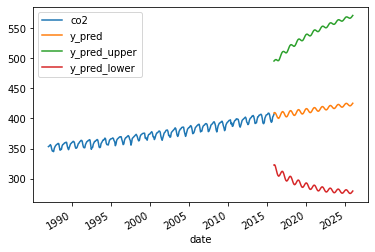

In [17]:
kff.get_combined_result().plot()

## Run by another data

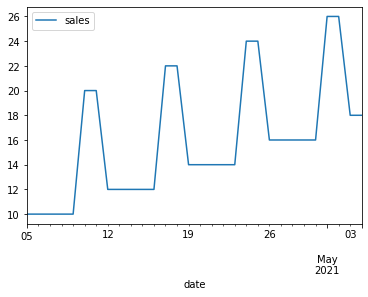

In [18]:
df2 = pd.read_csv("./sales.csv", index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.plot()

In [19]:
kff2 = KfForecaster(df2, seasonal_freq='1w')

In [20]:
kff2.run(10, ci=0.99)

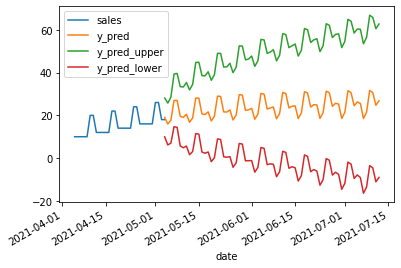

In [21]:
kff2.get_combined_result().plot()